# Predicting House Prices in King County, Washington
## Linear Regression Model
### by Christine Egan

## Alternative Hypothesis:
Location, size, quality, and age have an association with house prices in King County.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
from scipy.stats import zscore

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

%matplotlib inline
from functions1 import std_describe, percent_null_df, obtain_data
from functions1 import idx_select_sort_set, remove_dupes, find_nulls
from functions1 import rm_outliers_by_zscore, corr_heat_map, draw_qqplot
from functions1 import reg_summary, get_residual, validate_reg_assumptions

## 1. Obtaining Data

In [2]:
data = obtain_data('https://raw.githubusercontent.com/xinegan88/Module-2-Project/master/kc_house_data.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## 2. Scrubbing Data

### i. Selecting, Sorting, and Setting the Index
Examining the first few rows of the dataframe, we can see that there is column called 'id.' We can assume that each house is given its own unique id number. However, since there is also a date column, we should check for duplicates in both 'id' and 'date' before we set the index to 'id.' In addition, it would be helpful to transform 'date' into a datetime object so we can use it to create other features later on.

### ii. Identifying Null Values
The columns 'view' and 'waterfront' contain very little data. In the 'waterfront' column, we can see that there are only 146 properties out of more than 21,000 properties that can be considered waterfront properties. From this perspective, it seems like an unlikely predictor. Similarly, in 'view', only a small number of properties have ever been viewed. Due to this reasons, we will drop these columns. In 'yr_renovated', nearly 93% of the data is null or 0.0. Due to this, it also seems like a poor choice of a predictor and should be dropped.

### iii. Changing Data Types
In the information above, 'sqft_basement' is described as an 'object' when it is clear that the data in the column should be numeric. First, we will check the values to make sure they are all numeric, then we will change the column to a numeric data type. For some reason, there are a bunch of question marks in this column. Since it is a few hundred rows, we don't want to completely eliminate them from the data set. We will set them to '0'.

In [3]:
#i. select, sort, and set the index, change the date to a datetime object
indices = ['id', 'date']
data = idx_select_sort_set(data, indices)
data['date'] =  pd.to_datetime(data.date, infer_datetime_format=True)

# ii. identifying null values and taking action
print(find_nulls(data))
data = data.drop(['view', 'waterfront'], axis=1) # only 146 wf properties, very few for view as well

# print(data[data.yr_renovated.notna() & data.yr_renovated != 0].shape) --> only 746 have reno info!
data = data.drop('yr_renovated', axis=1)

# iii. changing data types
print('sqft_basement value counts:\n', data.sqft_basement.value_counts())
data['sqft_basement'] = data.sqft_basement.replace('?', '0')
data['sqft_basement'] = pd.to_numeric(data.sqft_basement, errors='coerce')
data['sqft_basement'] = data.sqft_basement.fillna('0')


                  Index Report                       
<------------------------------------------------------>
              Primary Index Set as:  id
            Secondary Index Set as:  date 


                Duplicate Report                  
<------------------------------------------------------>
            353  duplicates found in  id
            167  duplicates found in  date
           177 duplicates removed. 


              Null & Unique Values Report                  
               for Columns with Null Values                  
<------------------------------------------------------>
waterfront
-------------
Null values:  2345
Unique values:  3 

Value Counts
------------
0.0    18929
1.0      146
Name: waterfront, dtype: int64 

view
-------------
Null values:  63
Unique values:  6 

Value Counts
------------
0.0    19253
2.0      956
3.0      505
1.0      329
4.0      314
Name: view, dtype: int64 

yr_renovated
-------------
Null values:  3813
Unique values:  71 

Valu

## 3. Exploring Data

### i. First Check for Outliers
We can see that the price column has some exetreme outliers. I think that removing some of the most exetreme outliers seem to be in the higher range, however there are some in the lower range as well.

In [4]:
target = ['price']
drop_cols = ['date', 'lat', 'long', 'zipcode'] # not necessary for histogram
std_describe(data.drop(drop_cols, axis=1)) # getting preliminary information about outliers

                  Description with |3| STD Report                          
<------------------------------------------------------------------------->
               price      bedrooms     bathrooms   sqft_living      sqft_lot  \
count   2.142000e+04  21420.000000  21420.000000  21420.000000  2.142000e+04   
mean    5.413827e+05      3.373950      2.118429   2083.132633  1.512804e+04   
std     3.677008e+05      0.925405      0.768720    918.808412  4.153080e+04   
min     7.800000e+04      1.000000      0.500000    370.000000  5.200000e+02   
25%     3.240000e+05      3.000000      1.750000   1430.000000  5.040000e+03   
50%     4.500000e+05      3.000000      2.250000   1920.000000  7.614000e+03   
75%     6.450000e+05      4.000000      2.500000   2550.000000  1.069050e+04   
max     7.700000e+06     33.000000      8.000000  13540.000000  1.651359e+06   
+3_std  1.644485e+06      6.150163      4.424589   4839.557868  1.397204e+05   
-3_std -5.617195e+05      0.597736     -0.187731

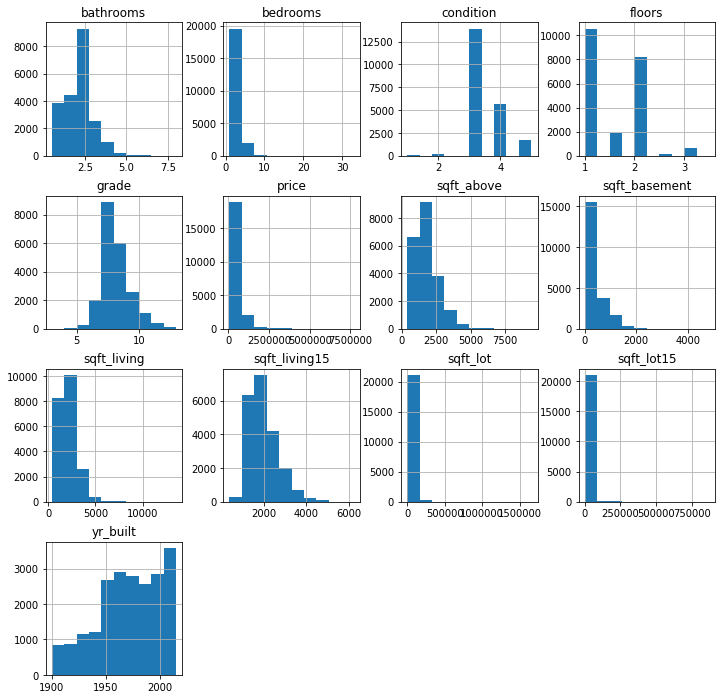

In [5]:
data.drop(drop_cols, axis=1).hist(figsize=(12,12));

### ii. Addressing Outliers by Z-Score
The columns 'price', 'bedrooms', and 'bathrooms' seem to have some outliers with exetreme values on the higher end. I want restrict the data to values that have a z-score with an absolute value of less than 3. This will enable the data to have some degree of variation, without allowing exetreme outliers to strongly influence the data.

In [6]:
cols = ['price', 'bedrooms', 'bathrooms']
data = rm_outliers_by_zscore(data, cols)


              Outlier Removal Report                  
         for columns:  ['price', 'bedrooms', 'bathrooms']
<------------------------------------------------------>

 price 
-------------
Number of Outliers Removed:  403
1.881 % of the total rows.


 bedrooms 
-------------
Number of Outliers Removed:  52
0.243 % of the total rows.


 bathrooms 
-------------
Number of Outliers Removed:  98
0.458 % of the total rows.

------------------------------------------------------------
Total percentage of data removed:  2.58
Total rows of data removed:  553
New length of dataframe:  20867
------------------------------------------------------------


### ii. Creating/Modifying Features
#### How can the features be modified to address location, size, age, quality, and functionality?

a. Binary Features
* In bedrooms and bathrooms, the exetreme outliers have been removed by z-score. While I still want to explore the relationship between the number of bedrooms and bathrooms and the price of a home, I think that adding a column for each possible amount will add unncessary complexity. A soultion is to turn them into binary variables that capture if the number of bathrooms falls beneath the 75th percentile, 'four_plus_bedrooms', and 'three_plus_bathrooms.'
* In grade, outliers were not addressed by z-score, however it should be taken into account that some properties with high grades may have been eliminated when the outliers were removed from 'price.' In this case we will also use the 75th percentile to create a binary variable, 'eight_plus_grade.'
* In'sqft_basement' is exetremely skewed because houses with no basements are represented by '0'. I think one way to still use this feature as a predictor is to work with it as a binary.

b. Reimagining Price
* One column that can help me to build other columns using averages, would be a column called 'price_per_sqft_living', combining 'price' and 'sqft_living.' It would not be wise to use this column as a predictor, but it can be used to create new features.

c. Using Averages
* Using price, I can obtain the average price per zipcode, allowing me to group zipcodes and properties.
* With sqft, I can obtain the average sqft_living per zipcode.
* Combining these two, I can obtain the average price per square foot by zipcode.

d. Determining Age from Dates
* A better way to use the date information provided is to transform it into a feature that expresses the age of the home. For some reason there were 12 values that had -1 as the age of the home. Since it was just a few, they were dropped.

In [7]:
# a. creating some binary features
data['four_plus_bedrooms'] = data.bedrooms.apply(lambda x: 1 if x >= 4 else 0)
data['three_plus_bathrooms'] = data.bedrooms.apply(lambda x: 1 if x >= 3 else 0)
data['eight_plus_grade'] = data.grade.apply(lambda x: 1 if x >= 8 else 0)
data['basement'] = data.sqft_basement.apply(lambda x: 1 if x > 0 else 0)

# b. creating new feature to describe price per square foot
data['price_per_sqft_living'] = data.price/data.sqft_living

# c. creating another feature for avg price by zip and another feature average sqft by zip
avg_price = data.groupby(['zipcode', 'price']).sum().reset_index().groupby('zipcode').mean().astype(int)
d = avg_price.price.to_dict()
data['zip_avg_price'] = data.zipcode.map(d)

avg_sqft_living = data.groupby(['zipcode', 'sqft_living']).sum().reset_index().groupby('zipcode').mean().astype(int)
d = avg_price.sqft_living.to_dict()
data['zip_avg_sqft'] = data.zipcode.map(d)

# creating another feature by combining the other two
data['zip_avg_pp_sqft'] = round((data.zip_avg_price/data.zip_avg_sqft), 0)

# d. determining age from date information
data['yr_sold'] = pd.DatetimeIndex(data['date']).year
data['age_at_sale'] = data.yr_sold - data.yr_built.astype(int) # age of house on date sold

print(sorted(list(data.age_at_sale.unique()))) # not sure why some are -1
print(data[data.age_at_sale == -1].shape[0]) # how many?
data = data[data.age_at_sale != -1] # eliminated

[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]
12


### iii. Dropping Features
Some of these features don't seem essential to testing my hypothesis.

#### Eliminated
| Feature     | Reason for Elimination |
|:---------   | :-----------|
| date     | Transformed to create 'age_at_sale' using 'yr_built'. |
| yr_renovated | There was a lot of missing data, making it an unsuitable predictor. |
| floors       | This information was redundant, and similar information could be obtained by examining square footage and number of rooms. |
| waterfront   | There was a lot of missing data, making it an unsuitable predictor. |
| view         | There was a lot of missing data, making it an unsuitable predictor. |
| lat          | Not needed for this analysis. |
| long         | Not needed for this analysis |
| sqft_above   | This information was redundant, and similar information could be obtained by examining square footage and number of rooms. |
| sqft_basement| The skew of this information was severe, so it was used to create a more useful feature, then dropped. |
| sqft_lot     | Exetreme outliers made this data fairly unreliable, and efforts to normalize compromised the accuracy of the results. |
| sqft_living15| Demonstrated high correlation with more useful square foot metrics, such as 'sqft_living'.
| sqft_lot15   | The elimination of other features made it irrelevant for analysis.     |
|bedrooms     | Outliers with z-score greater than 3 were removed. Then, it was used to create the feature '4_plus_bedrooms', which contained 0 or 1 to indicate if there were more or less than 4 bedrooms. |
|bathrooms    | Outliers with z-score greater than 3 were removed. Then, it was used to create the feature '3_plus_bathrooms', which contained 0 or 1 to indicate if there were more or less than 3 bathrooms. |
|grade        | It was used to create the feature '8_plus_grade', which contained a 0 or 1 to indicate if the grade was more or less than 8. 
|yr_built     | Transformed to create 'age_at_sale' using 'date'.
|zipcode      | Transformed to create the features 'zip_avg_price', 'zip_avg_sqft', 'zip_avg_pp_sqft' using 'price.' |

#### Final Features
The objective of this model was to test which features have a significant influence on the price of a home in King County. To facilitate this, features were chosen to reflect, the size of the home, the age of the home, the quality of the home, and the location of the home.  

| Feature                 | Indicates:                                 |
|:---------               | :-----------                               |
| 4_plus_bedrooms         |  size                                      |
| 3_plus_bathrooms        |  size                                      |
| sqft_living             |  size                                      |
| basement                |  size                                      |   
| zip_avg_pp_sqft_living  |  a relationship between size and price     |
| zip_avg_sqft            |  a relationship between size and location  |
| age_at_sale             |  age                                       |
| condition               |  age & quality                             |
| 8_plus_grade            |  quality                                   | 

In [8]:
drop_cols = ['price', 'bedrooms', 'bathrooms', 'grade', 
             'sqft_basement', 'price_per_sqft_living', 
             'sqft_above', 'sqft_basement', 'sqft_lot', 
             'sqft_living15', 'sqft_lot15', 'zip_avg_price',
             'date', 'yr_sold', 'yr_built', 'lat', 'long',
             'zipcode', 'floors']

In [9]:
t_data = data.copy()

### iv. Multicollinearity Check

Text(0.5, 1, 'King County, Washington Housing Data \n Correlation Matrix Heat Map \n')

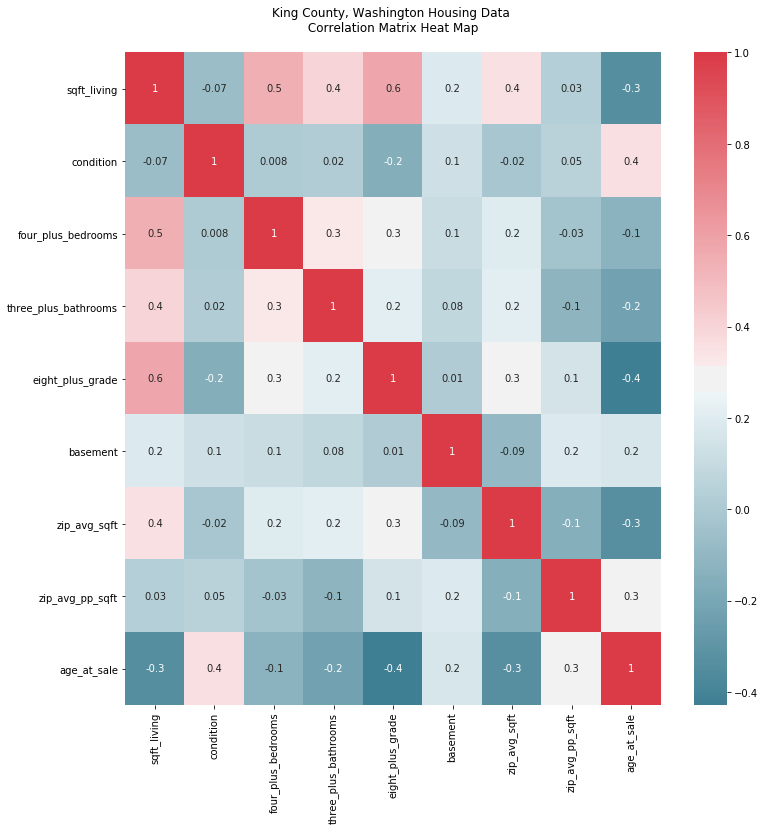

In [10]:
corr_heat_map(data, drop_cols)
plt.title('King County, Washington Housing Data \n Correlation Matrix Heat Map \n')

## 4. Modeling and Interpreting the Data

### i. The Comprehensive Model

Retrieving OLS Summary...

const                  -636050.301054
sqft_living                183.673047
condition                17140.420184
four_plus_bedrooms      -22737.425851
three_plus_bathrooms    -15150.496754
eight_plus_grade         62463.487224
basement                -18431.460434
zip_avg_sqft                83.664408
zip_avg_pp_sqft           2458.578317
age_at_sale                860.433704
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     5197.
Date:                Sun, 20 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:18:25   Log-Likelihood:            -1.9196e+05
No. Observations:               14598   AIC:                         3.839e+05
Df Residuals:            

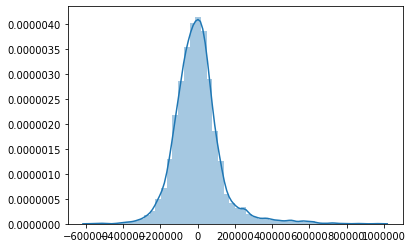

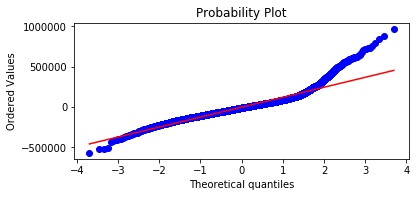

Mean of Residuals:  -1016.4868739187006

Displaying Regplot...



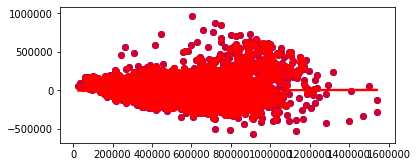

In [11]:
drop_cols.remove('price')
x = t_data.drop(drop_cols, axis=1)
X = x.drop(['price'], axis=1)
y = x['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=44)

validate_reg_assumptions(X, X_train, X_test, y_train, y_test)

In [12]:
%%html
<style>
table {float:left}
</style>

### Interpretation
The R-Squared/Adjusted R-Squared value seems to indicate that the model is accurate and that the independent variables are not unncessary. The p-values are all below the threshold, verifying that we can reject the null hypothesis that location, size, quality, and age have no association with price. 

#### Negative
| Feature     | Interpretation |
|:---------   | :-----------|
|four_plus_bedrooms |  More bedrooms than necessary indicates smaller, less functional bedrooms. |
|basement            | Having a basement is a lot of hassle, and if it doesn't add extra functionality to a home it a liability. |
|three_plus_bathrooms| More bathrooms are more of a liability and don't provide extra functionality unless it is an exceptionally large family |    

#### Positive
| Feature         | Interpretation |
|:---------       | :-----------|
|sqft_living      | On average, in King County, each square foot is associated with 182 increase in price. |
|condition        | Houses in better condition command a higher price on average. |
|eight_plus_grade | Having a grade in the upper quartile grade seems to have a very strong association with price.|
|zip_avg_sqft     | The average square footage of homes in your zipcode is associated with a small increase price. While the coefficient seems small, it can lead to huge price increases as the average increases.|
|zip_avg_pp_sqft  | The average price per square foot per zip code is associated with higher values, because location matters!|
|age_at_sale      | The age of a home can increase the price by nearly $900 per year, which could be associated with highly coveted homes in historical districts|

### ii. Zipcode Group Model
#### Can we isolate each zipcode group and determine the association with price?

In [13]:
t_data['zip_avg_pp_sqft_one'] = t_data.zip_avg_pp_sqft.apply(lambda x: 1 if x <= 134 else 0)
t_data['zip_avg_pp_sqft_two'] = t_data.zip_avg_pp_sqft.apply(lambda x: 1 if 134 < x <= 171 else 0)
t_data['zip_avg_pp_sqft_three'] = t_data.zip_avg_pp_sqft.apply(lambda x: 1 if 171 < x <= 210 else 0)
t_data['zip_avg_pp_sqft_four'] = t_data.zip_avg_pp_sqft.apply(lambda x: 1 if 210 < x <= 518 else 0)

Retrieving OLS Summary...

const                   -117088.136199
sqft_living                 186.229471
condition                 15239.987312
four_plus_bedrooms       -22280.969479
three_plus_bathrooms     -11632.166677
eight_plus_grade          69569.036350
basement                 -18092.586394
zip_avg_sqft                 58.670799
age_at_sale                 981.714365
zip_avg_pp_sqft_one     -194177.994414
zip_avg_pp_sqft_two      -80064.196850
zip_avg_pp_sqft_three     11853.443970
zip_avg_pp_sqft_four     145300.611095
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     3717.
Date:                Sun, 20 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:18:26   Log-Likelihood: 

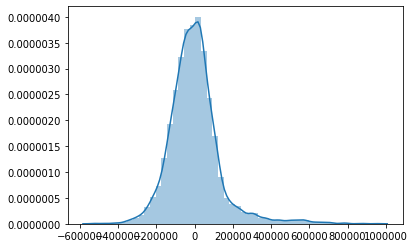

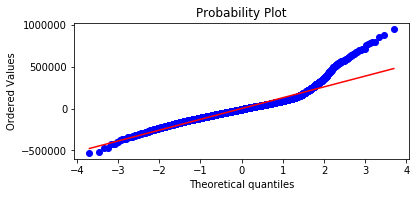

Mean of Residuals:  120.89391556428663

Displaying Regplot...



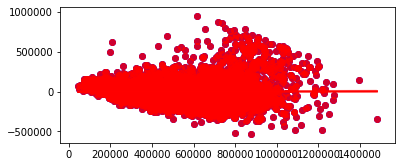

In [14]:
drop_cols.append('zip_avg_pp_sqft')
x = t_data.drop(drop_cols, axis=1)
X = x.drop(['price'], axis=1)
y = x['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=44)

validate_reg_assumptions(X, X_train, X_test, y_train, y_test)

### Interpretation
The R-Squared/Adjusted R-Squared value seems to indicate that the model is accurate and that the independent variables are not unncessary. However, it did not perform as well as the Comprehensive Model. The p-values are all below the threshold, verifying that we can reject the null hypothesis that location, size, quality, and age have no association with price. 

Of the features that were carried over from the Comprehensive Model, they remained mostly unchanged in the Zipcode Group Model. However, we did see a 10% increase in the association between age at sale and price. 

Of the Zipcode Group Features, it can be said that groups one and two have price per square foot averages that fall below the median, and that groups three and four fall above the median. Given that the median price of a home in King County is 445,800(USD). the coefficients demonstrate that on average, homes in group one and two will cost 196K(USD), and 81K(USD) less than the median. On the other hand, groups three and floor are associated with an average of a 12K(USD) and 144K(USD) increase respectively.

### iii. Modeling by Zipcode
#### Can we improve accuracy by trying one model for each zipcode group, and see what associations emerge for each tier?

In [15]:
zip_avg_pp_sqft_one =  t_data[t_data.zip_avg_pp_sqft_one == 1].drop(['zip_avg_pp_sqft_one', 'zip_avg_pp_sqft_two','zip_avg_pp_sqft_three','zip_avg_pp_sqft_four'], axis=1)
zip_avg_pp_sqft_two =  t_data[t_data.zip_avg_pp_sqft_two == 1].drop(['zip_avg_pp_sqft_one', 'zip_avg_pp_sqft_two','zip_avg_pp_sqft_three','zip_avg_pp_sqft_four'], axis=1)
zip_avg_pp_sqft_three = t_data[t_data.zip_avg_pp_sqft_three == 1].drop(['zip_avg_pp_sqft_one', 'zip_avg_pp_sqft_two','zip_avg_pp_sqft_three','zip_avg_pp_sqft_four'], axis=1)
zip_avg_pp_sqft_four = t_data[t_data.zip_avg_pp_sqft_four == 1].drop(['zip_avg_pp_sqft_one', 'zip_avg_pp_sqft_two','zip_avg_pp_sqft_three','zip_avg_pp_sqft_four'], axis=1)

#### Zipcode Group 1

Retrieving OLS Summary...

const                   42987.804187
sqft_living               126.846802
condition                6168.817792
four_plus_bedrooms     -22833.751471
three_plus_bathrooms   -21273.432532
eight_plus_grade        29311.048567
basement               -12145.512542
zip_avg_sqft                5.297983
age_at_sale               160.876679
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     687.9
Date:                Sun, 20 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:18:28   Log-Likelihood:                -46880.
No. Observations:                3717   AIC:                         9.378e+04
Df Residuals:                    3708   BIC:                         9.3

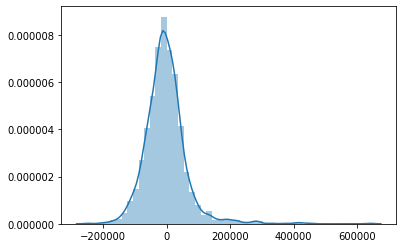

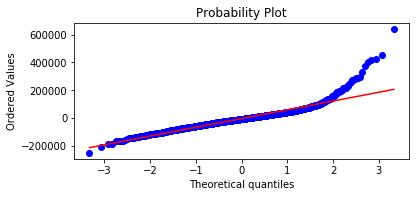

Mean of Residuals:  -2812.0438350753916

Displaying Regplot...



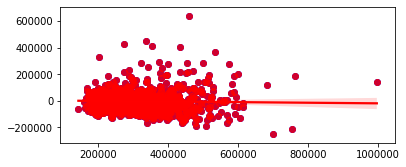

In [16]:
x = zip_avg_pp_sqft_one.drop(drop_cols, axis=1)
X = x.drop(['price'], axis=1)
y = x['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=44)

validate_reg_assumptions(X, X_train, X_test, y_train, y_test)

#### Zipcode Group 2

Retrieving OLS Summary...

const                  -69931.440441
sqft_living               168.301578
condition               11754.179674
four_plus_bedrooms     -29123.886745
three_plus_bathrooms   -31460.432955
eight_plus_grade        77695.073750
basement                -8313.907879
zip_avg_sqft               44.376368
age_at_sale               440.278285
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     875.8
Date:                Sun, 20 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:18:29   Log-Likelihood:                -47583.
No. Observations:                3658   AIC:                         9.518e+04
Df Residuals:                    3649   BIC:                         9.5

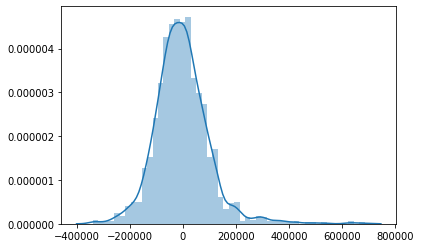

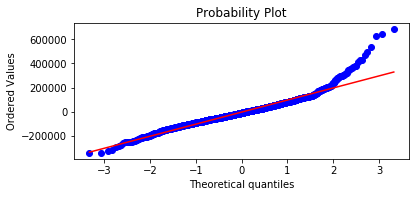

Mean of Residuals:  -3467.8605892173437

Displaying Regplot...



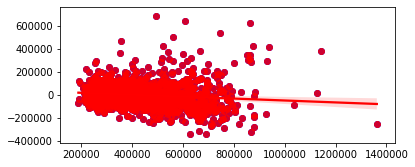

In [17]:
x = zip_avg_pp_sqft_two.drop(drop_cols, axis=1)
X = x.drop(['price'], axis=1)
y = x['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=44)

validate_reg_assumptions(X, X_train, X_test, y_train, y_test)

#### Zipcode Group 3

Retrieving OLS Summary...

const                  -129188.711976
sqft_living                207.266853
condition                20018.064337
four_plus_bedrooms      -21726.928588
three_plus_bathrooms    -34419.901114
eight_plus_grade         51743.800520
basement                -13867.460028
zip_avg_sqft                55.865499
age_at_sale                954.187162
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     936.2
Date:                Sun, 20 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:18:30   Log-Likelihood:                -50276.
No. Observations:                3791   AIC:                         1.006e+05
Df Residuals:                    3782   BIC:                   

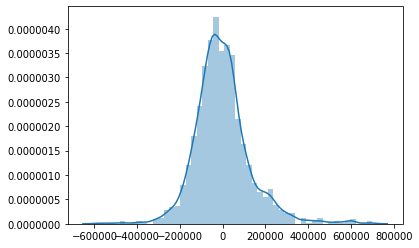

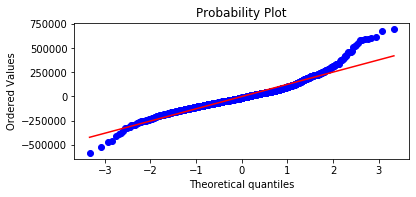

Mean of Residuals:  -1047.3067437343498

Displaying Regplot...



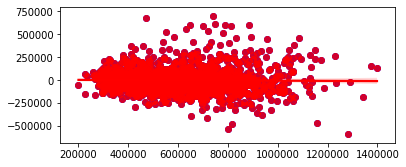

In [18]:
x = zip_avg_pp_sqft_three.drop(drop_cols, axis=1)
X = x.drop(['price'], axis=1)
y = x['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=44)

validate_reg_assumptions(X, X_train, X_test, y_train, y_test)

#### Zipcode Group 4

Retrieving OLS Summary...

const                  -181615.615111
sqft_living                226.907587
condition                13730.819158
four_plus_bedrooms       -7587.054549
three_plus_bathrooms    -21376.634181
eight_plus_grade        128621.309094
basement                -31126.040369
zip_avg_sqft                92.227640
age_at_sale               1326.786549
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     753.7
Date:                Sun, 20 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:18:31   Log-Likelihood:                -46165.
No. Observations:                3431   AIC:                         9.235e+04
Df Residuals:                    3422   BIC:                   

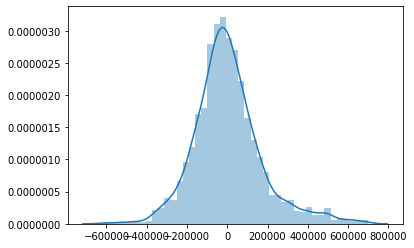

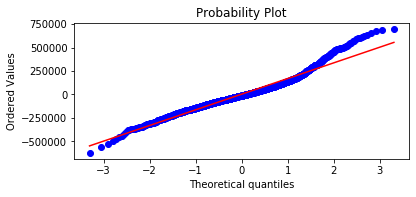

Mean of Residuals:  3795.0532680751044

Displaying Regplot...



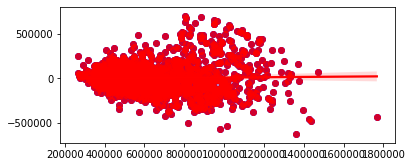

In [19]:
x = zip_avg_pp_sqft_four.drop(drop_cols, axis=1)
X = x.drop(['price'], axis=1)
y = x['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=44)

validate_reg_assumptions(X, X_train, X_test, y_train, y_test)

### Interpretation

#### R-Squared/Adjusted R-Squared Comparison
| Zipcode Group | R-Squared/Adjusted R-Squared |
|:---------     | :-----------|
|one            | 0.597/0.597 |
|two            | 0.658/0.657 |
|three          | 0.664/0.664 |
|four           | 0.638/0.637 |

#### Zipcode Group 1
Out of all the of the groups, the model was the least effective at predicting prices within this group. According to the P-Values, we cannot reject the null hypothesis with respect zipcode average price per square foot. This is a departure from the other models, where this was an important factor.

#### Zipcode Group 2
The model was much better at predicting price than in Zipcode Group 1. However, it did not perform as well as The Comprehensive Model, or the Zip Code Group Model.

#### Zipcode Group 3
Out of all the zipcode groups, the model performed best when predicting for Zipcode Group 3, with Zipcode Group 2 as a close second. This is somewhat predictable because they are both in close proximity to the mean.

#### Zipcode Group 4
The model predicted Zip Group 4 fairly well. However, it is clear that the null hypothesis with respect to the number of bedrooms cannot be rejected when predicing home prices for Zipcode Group 4. 

#### Overall
As mentioned above, the model seemed to perform the best when predicting Zipcode Groups 2 and 3. This is most likely due to their proximity to the median price. On the other hand, we can see in Groups 3 and 4, that graphs of the residuals appear more normal and less skewed than groups 1 and 2. 

## Conclusions
Overall, I think it is safe to say I can reject the null hypothesis. The data suggests that there is a relationship between predictors of location, size, quality, and age with the dependent variable of price. However, these associations were more pronounced in some models, especially when considering the granular view of each zipcode group. 

The most accurate model seems to be the Comprehensive Model, followed by the Zipcode Group Model. The model itself became less accurate when I tried to apply it to each zipcode group individually. One explanation for this could be that each zipcode in the zipcode group was weighted equally, without taking into account the number of instances of that zipcode in the data. Thus, the average for that zipcode might only represent one home. One way to improve accuracy would be to find a way to neutralize these differences.

I also think that this analysis could be improved if population data were included in for each zipcode. It is unclear what effect population might have on price. For example, a zipcode that skews more affluent might have a lower population, however the affluent quality of the neighborhood has a more significant increase on price. There is also an argument to be made that in more crowded areas, the price per square foot might be higher as well. It is possible that using median incomes in addition to population might reveal more about the role population.

In addition in order to expand on the role of location, I think that the lattitude and longitude data would be a useful feature to explore the proximity between a home and Seattle. One hypothesis is that there is an association between income, population, and proximity to Seattle that would influence what a buyer would be willing to pay for a house. It might also be interesting to see how fluctuations in population and incomes might predict how housing prices might rise or fall over time.